## Imports

In [3]:
try:
    from pathlib import Path
    import pandas as pd
    import matplotlib.pyplot as plt
    from lib.lib_utils import Utils
    import seaborn as sns
    from lib.lib_defect_analysis import Features
    from tqdm import tqdm
except Exception as e:
    print(f"Some module are missing: {e}\n")

data_path = Path().resolve().joinpath("data")
xyz_files_path = data_path.joinpath("xyz_files")
yolo_model_path = data_path.joinpath("models", "best.pt")
images_path = data_path.joinpath("images")
crops_path = data_path.joinpath("crops")

plt.style.use("seaborn-v0_8-paper")

## Generate images from xyz files

In [4]:
Utils.from_xyz_to_png(xyz_files_path, images_path)

## YOLO inference to generate binary crops

In [5]:
Utils.generate_yolo_crops(
    images_path, crops_path, yolo_model_path, binary_mask=True, device="cpu"
)

## Features extraction and dataframe generation

In [9]:
filepath = data_path.joinpath("features.csv").exists()

In [10]:
filepath

False

In [12]:
if not filepath:
    images = [
        f for f in crops_path.iterdir() if f.suffix.lower() in Features.IMAGE_EXTENSIONS
    ]

    features = {}

    for image in tqdm(images):
        if len(features) == 0:
            keys_list = list(features.keys())
            df = pd.DataFrame(columns=keys_list)
        else:
            features.clear()

        name = image.stem.split("_crop")[0]

        with open(str(xyz_files_path.joinpath(f"{name}.xyz")), "r") as file:
            first_line = file.readline()
        n_atoms = int(first_line.strip())

        features.update({"file_name": name})
        features.update({"n_atoms": n_atoms})

        shape_features = Features.extract_shape_features(image, grayscale=True)
        if shape_features is not None:
            features.update(shape_features)

        edge_features = Features.extract_edge_features(image, grayscale=True)
        if edge_features is not None:
            features.update(edge_features)

        texture_features = Features.extract_texture_features(image)
        if texture_features is not None:
            features.update(texture_features)

        new_row = pd.Series(features)
        df = pd.concat([df, new_row.to_frame().T], ignore_index=True)

    grouped_df = (
        df.groupby("file_name")
        .agg(
            {
                "n_atoms": "first",
                "area": "sum",
                "num_pixels": "sum",
                "perimeter": "sum",
                "circularity": lambda x: (x * df.loc[x.index, "area"]).sum()
                / df.loc[x.index, "area"].sum(),
                "solidity": lambda x: (x * df.loc[x.index, "area"]).sum()
                / df.loc[x.index, "area"].sum(),
                "compactness": lambda x: (x * df.loc[x.index, "area"]).sum()
                / df.loc[x.index, "area"].sum(),
                "feret_diameter": lambda x: (x * df.loc[x.index, "area"]).sum()
                / df.loc[x.index, "area"].sum(),
                "eccentricity": lambda x: (x * df.loc[x.index, "area"]).sum()
                / df.loc[x.index, "area"].sum(),
                "number_of_edges": lambda x: (x * df.loc[x.index, "area"]).sum()
                / df.loc[x.index, "area"].sum(),
                "edge_density": lambda x: (x * df.loc[x.index, "area"]).sum()
                / df.loc[x.index, "area"].sum(),
                "edge_density": lambda x: (x * df.loc[x.index, "area"]).sum()
                / df.loc[x.index, "area"].sum(),
                "GLCM_contrast": lambda x: (x * df.loc[x.index, "area"]).sum()
                / df.loc[x.index, "area"].sum(),
                "GLCM_homogeneity": lambda x: (x * df.loc[x.index, "area"]).sum()
                / df.loc[x.index, "area"].sum(),
                "GLCM_energy": lambda x: (x * df.loc[x.index, "area"]).sum()
                / df.loc[x.index, "area"].sum(),
                "GLCM_correlation": lambda x: (x * df.loc[x.index, "area"]).sum()
                / df.loc[x.index, "area"].sum(),
            }
        )
        .reset_index()
    )

    #
    original_df = pd.read_csv(xyz_files_path.joinpath("target_graphene_dftb.csv"))

    energy_dict = original_df.set_index("file_name")["total_energy_eV"].to_dict()
    fermi_dict = original_df.set_index("file_name")["fermi_level_ev"].to_dict()
    ip_dict = original_df.set_index("file_name")["IP_ev"].to_dict()
    ea_dict = original_df.set_index("file_name")["EA_ev"].to_dict()
    band_gap_dict = original_df.set_index("file_name")["band_gap_ev"].to_dict()

    # Aggiunta della colonna total_energy al primo dataframe
    grouped_df["total_energy_eV"] = grouped_df["file_name"].map(energy_dict)
    grouped_df["fermi_level_ev"] = grouped_df["file_name"].map(fermi_dict)
    grouped_df["IP_ev"] = grouped_df["file_name"].map(ip_dict)
    grouped_df["EA_ev"] = grouped_df["file_name"].map(ea_dict)
    grouped_df["band_gap_ev"] = grouped_df["file_name"].map(band_gap_dict)
    grouped_df["energy_per_atom"] = (
        grouped_df["total_energy_eV"] / grouped_df["n_atoms"]
    )
    grouped_df = grouped_df.dropna()

    grouped_df.to_csv(data_path.joinpath("features.csv"), index=False)
else:
    grouped_df = pd.read_csv(data_path.joinpath("features.csv"))

100%|██████████| 11515/11515 [00:23<00:00, 490.78it/s]


## Plot correlations

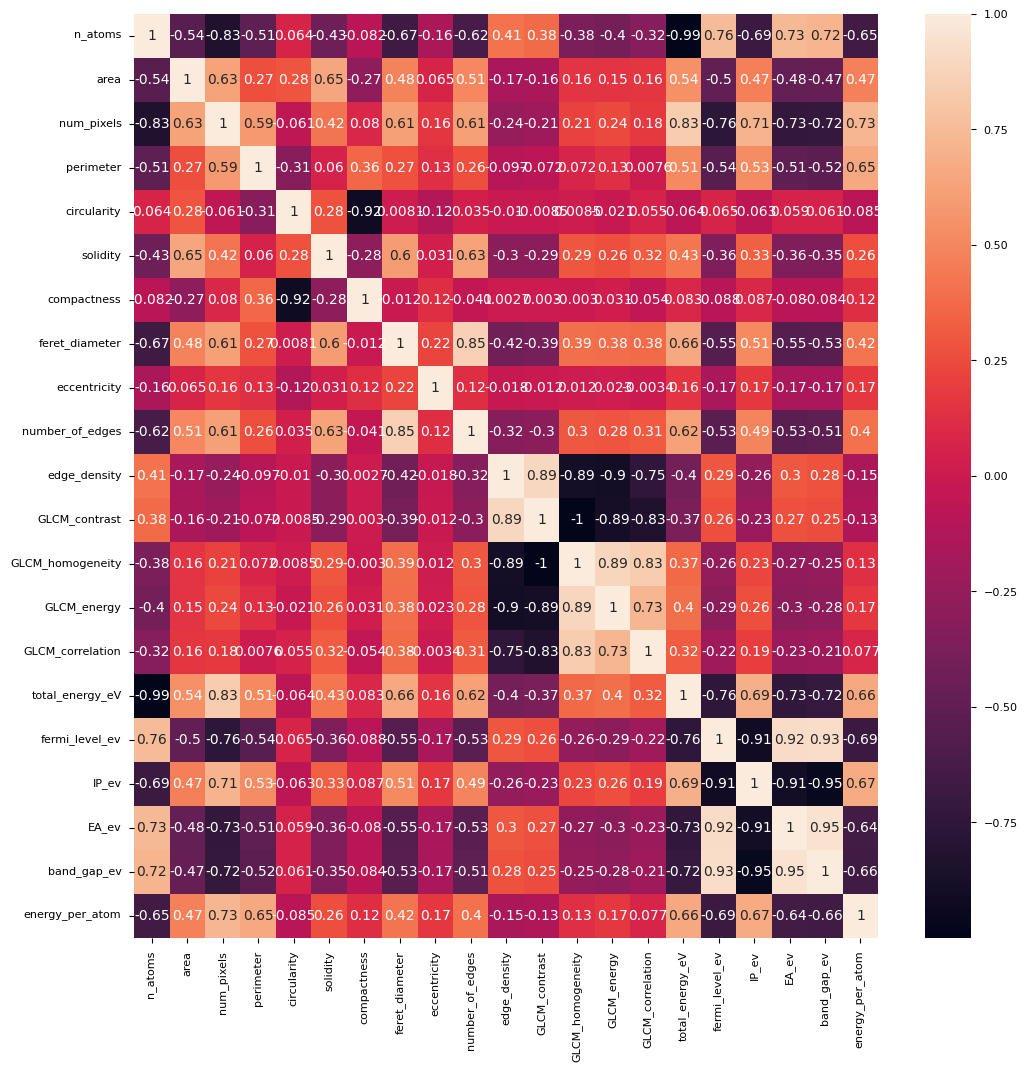

In [10]:
grouped_df = grouped_df.drop(grouped_df[grouped_df["total_energy_eV"] > -2500].index)

columns_to_drop = ["file_name"]
merged_df = grouped_df.drop(columns_to_drop, axis=1)

# stampo heatmap
corr = merged_df.corr(method="kendall")
target_correlation = corr[["total_energy_eV", "energy_per_atom"]]

fig = plt.figure(figsize=(12, 12))
sns.heatmap(corr, annot=True)

# stampo basic correlogram
# sns.pairplot(merged_df)
plt.show()

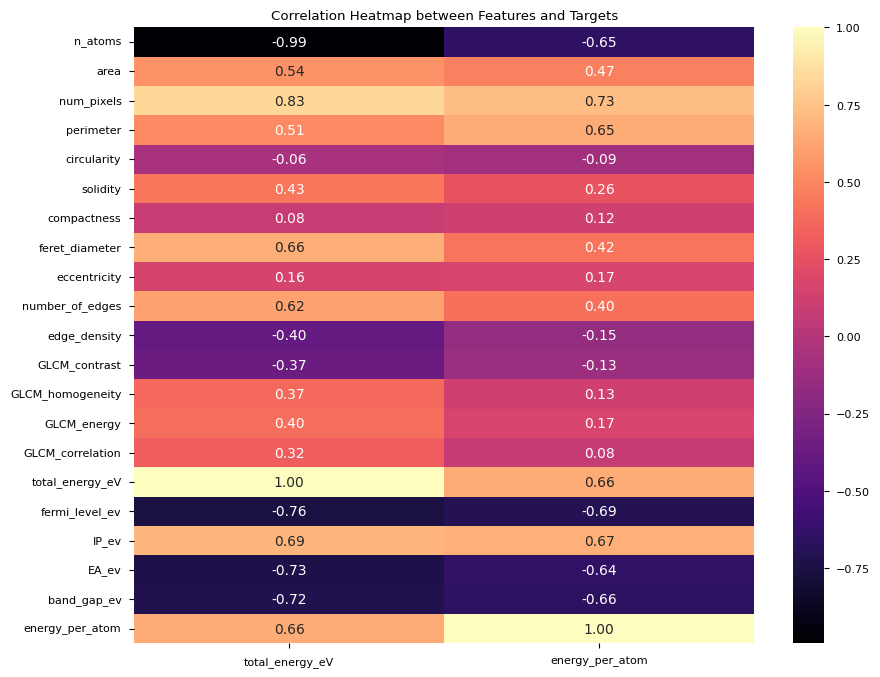

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(target_correlation, annot=True, cmap="magma", fmt=".2f")
plt.title("Correlation Heatmap between Features and Targets")
plt.show()

In [9]:
# g = sns.PairGrid(grouped_df)
# g.map_diag(sns.kdeplot)
# g.map_lower(sns.kdeplot)
# g.map_upper(sns.scatterplot)

## Total energy prediction

In [15]:
try:
    import matplotlib.pyplot as plt
    import numpy as np
    from sklearn import ensemble
    from sklearn.inspection import permutation_importance
    from sklearn.metrics import mean_squared_error
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import MinMaxScaler
    import scipy

except Exception as e:
    print(f"Some module are missing: {e}\n")

## Data preparation

In [16]:
if grouped_df.isna().any().any():
    print("Avviso: Il DataFrame contiene valori NaN.")
else:
    print("Il DataFrame non contiene valori NaN.")

Il DataFrame non contiene valori NaN.


In [261]:
# features_list = [ "area","perimeter", "circularity", "solidity", "compactness", "feret_diameter", "eccentricity", "number_of_edges", "edge_density", "mean_length_of_edges", "std_length_of_edges"]
feature_target = "compactness"
min_value = 0
max_value = 21
rows_to_drop = grouped_df[
    (grouped_df[feature_target] >= min_value)
    & (grouped_df[feature_target] <= max_value)
].index
df_filtered = grouped_df.drop(rows_to_drop)

In [262]:
# features_list = [ "area","perimeter", "circularity", "solidity", "compactness", "feret_diameter", "eccentricity", "number_of_edges", "edge_density", "mean_length_of_edges", "std_length_of_edges"]
feature_target = "eccentricity"
min_value = 0
max_value = 0.04
rows_to_drop = df_filtered[
    (df_filtered[feature_target] >= min_value)
    & (df_filtered[feature_target] <= max_value)
].index
df_filtered = df_filtered.drop(rows_to_drop)

In [13]:
target_list = [
    "file_name",
    "fermi_level_ev",
    "IP_ev",
    "EA_ev",
    "band_gap_ev",
    "energy_per_atom",
    "total_energy_eV",
]
features_df = df_filtered.drop(columns=target_list)

# Visualizza le distribuzioni delle features utilizzando seaborn

for column in features_df.columns:
    plt.figure(figsize=(6, 4))
    sns.histplot(data=features_df[column], kde=True, bins=np.sqrt(df_filtered.shape[0]))
    plt.title(f"Distribuzione di {column}")
    plt.xlabel("Valore")
    plt.ylabel("Conteggio")
    plt.show()

NameError: name 'df_filtered' is not defined

In [17]:
target = "fermi_level_ev"
features_list = [
    "area",
    "perimeter",
    "circularity",
    "solidity",
    "feret_diameter",
    "compactness",
    "eccentricity",
    "number_of_edges",
    "edge_density",
    "GLCM_correlation",
    "GLCM_energy",
    "GLCM_homogeneity",
    "GLCM_contrast",
]

X = grouped_df[features_list].values

y = grouped_df[target].values.flatten()  # array con tutti i valori raget total_energy

scaler = MinMaxScaler()
X_norm = scaler.fit_transform(X)

scaler2 = MinMaxScaler()
y_norm = scaler2.fit_transform(y.reshape(-1, 1))

## Split dataset and set hyperparameters

In [16]:
plt.figure(figsize=(8, 6))
sns.heatmap(df_filtered.isnull(), cmap="viridis", cbar=False, yticklabels=False)
plt.title("NaN nel DataFrame")
plt.xlabel("Colonne")
plt.ylabel("Righe")
plt.show()

NameError: name 'df_filtered' is not defined

<Figure size 800x600 with 0 Axes>

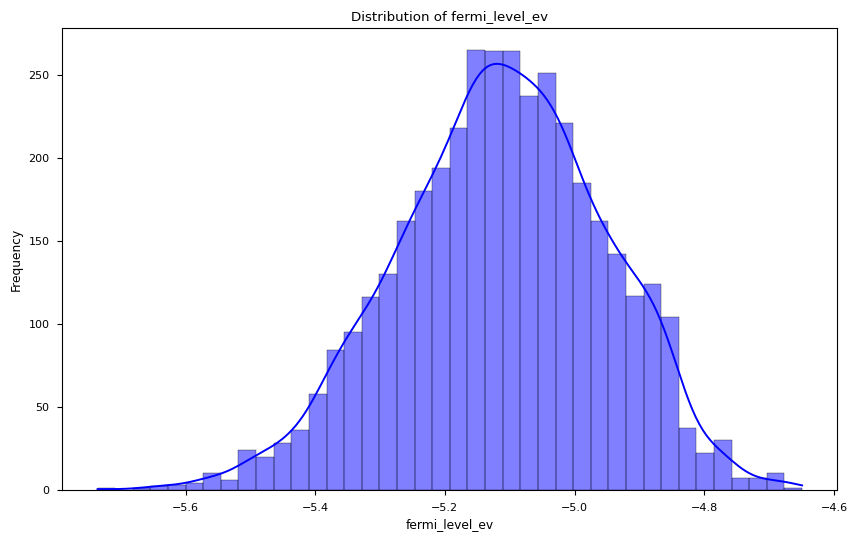

In [9]:
# Plot della distribuzione della variabile target total_energy
plt.figure(figsize=(10, 6))
sns.histplot(y, kde=True, color="blue")
plt.xlabel(target)
plt.ylabel("Frequency")
plt.title(f"Distribution of {target}")
plt.show()

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=3333
)

In [13]:
# np.save('./optuna/x_norm_ip_ev.npy', X_norm)
# np.save('./optuna/y_norm_ip_ev.npy', y_norm)

XGBOOST senza k-fold


In [19]:
import xgboost as xgb

# OPTUNA PARAMS Total_energy
# params = {
#     "n_estimators": 1850,
#     "learning_rate": 0.035250129884021043,
#     "max_depth": 9,
#     "gamma": 0.000731247172308212,
#     "min_child_weight": 8.408269160115502,
#     "colsample_bytree": 0.9702313623914688,
#     "subsample": 0.5094062459445882,
# }

# OPTUNA PARAMS IP_EV
params = {
    "n_estimators": 2770,
    "learning_rate": 0.010562915246990538,
    "max_depth": 10,
    "gamma": 0.0002985546393874009,
    "min_child_weight": 1.8685613953859606,
    "colsample_bytree": 0.9633894246849674,
    "subsample": 0.5195778253826636,
}
# params = {
#     "n_estimators": 1900,
#     "learning_rate": 0.01,
#     "max_depth": 9,
#     "gamma": 0.000731247172308212,
#     "min_child_weight": 8.408269160115502,
#     "colsample_bytree": 0.9702313623914688,
#     "subsample": 0.5094062459445882,
# }
# #model = ensemble.GradientBoostingRegressor(**params)
model = xgb.XGBRegressor(**params)
model.fit(X_train, y_train.ravel())

y_pred = model.predict(X_test)

In [18]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb

params = {
    "n_estimators": 2770,
    "learning_rate": 0.010562915246990538,
    "max_depth": 10,
    "gamma": 0.0002985546393874009,
    "min_child_weight": 1.8685613953859606,
    "colsample_bytree": 0.9633894246849674,
    "subsample": 0.5195778253826636,
}
model = xgb.XGBRegressor(**params)
target_list = [
    "fermi_level_ev",
    "IP_ev",
    "EA_ev",
    "band_gap_ev",

]
X = grouped_df[features_list].values
scores = []
for target in target_list:
    target_scores = []
    y = grouped_df[target].values.flatten()
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=3333
    )
    model.fit(X_train, y_train.ravel())

    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)

    mae = mean_absolute_error(y_test, y_pred)

    r2 = r2_score(y_test, y_pred)
    scores.append([mse, mae, r2])

In [19]:
scores_array = np.array(scores)

In [21]:
scores_array


array([[  0.0019567,    0.032809,     0.92519],
       [  0.0030509,    0.040925,     0.89036],
       [  0.0028066,    0.038754,      0.8962],
       [   0.011231,    0.077993,     0.89658]])

Text(0, 0.5, 'R2 score')

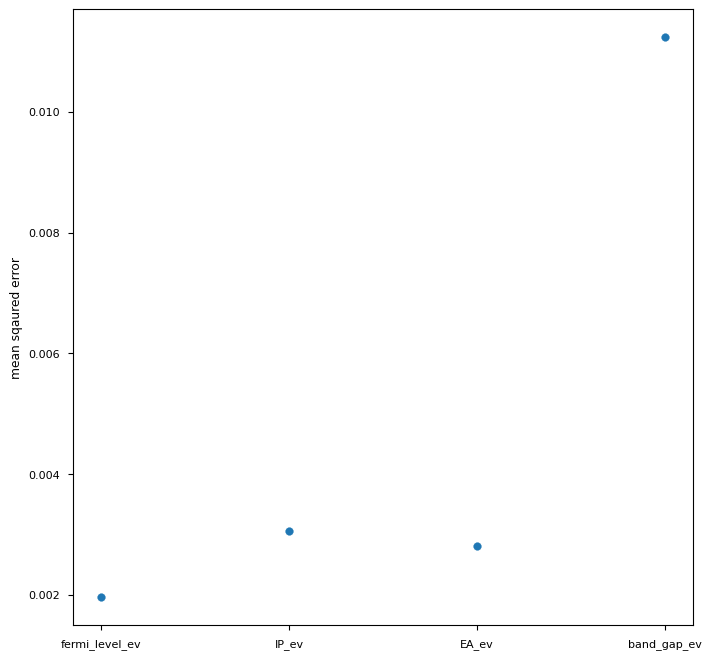

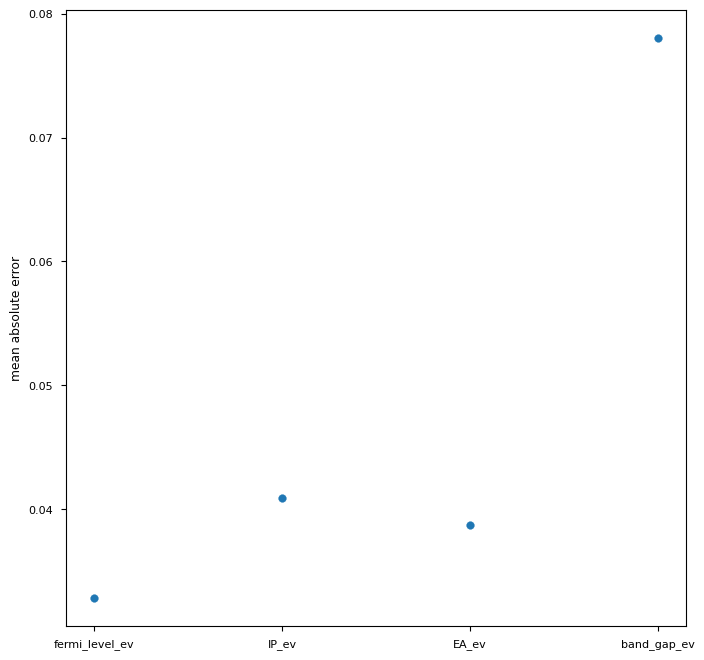

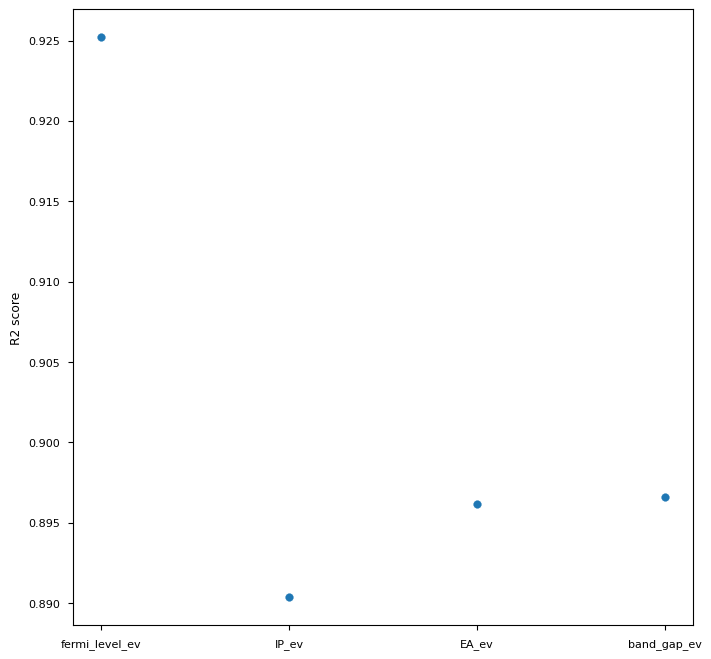

In [20]:
plt.figure(figsize=(8, 8))
plt.scatter(target_list, scores_array[:, 0])
plt.ylabel("mean sqaured error")
plt.figure(figsize=(8, 8))
plt.scatter(target_list, scores_array[:, 1])
plt.ylabel("mean absolute error")
plt.figure(figsize=(8, 8))
plt.scatter(target_list, scores_array[:, 2])
plt.ylabel("R2 score")

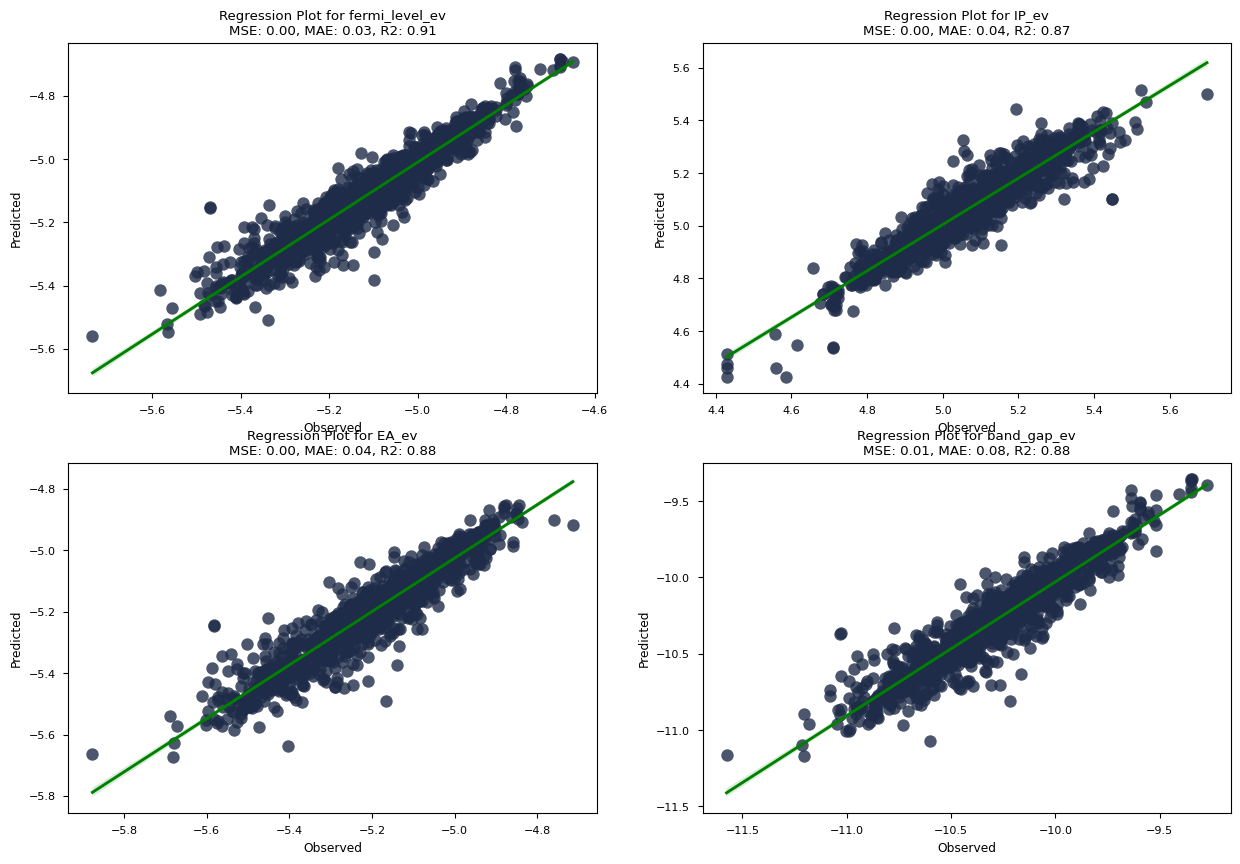

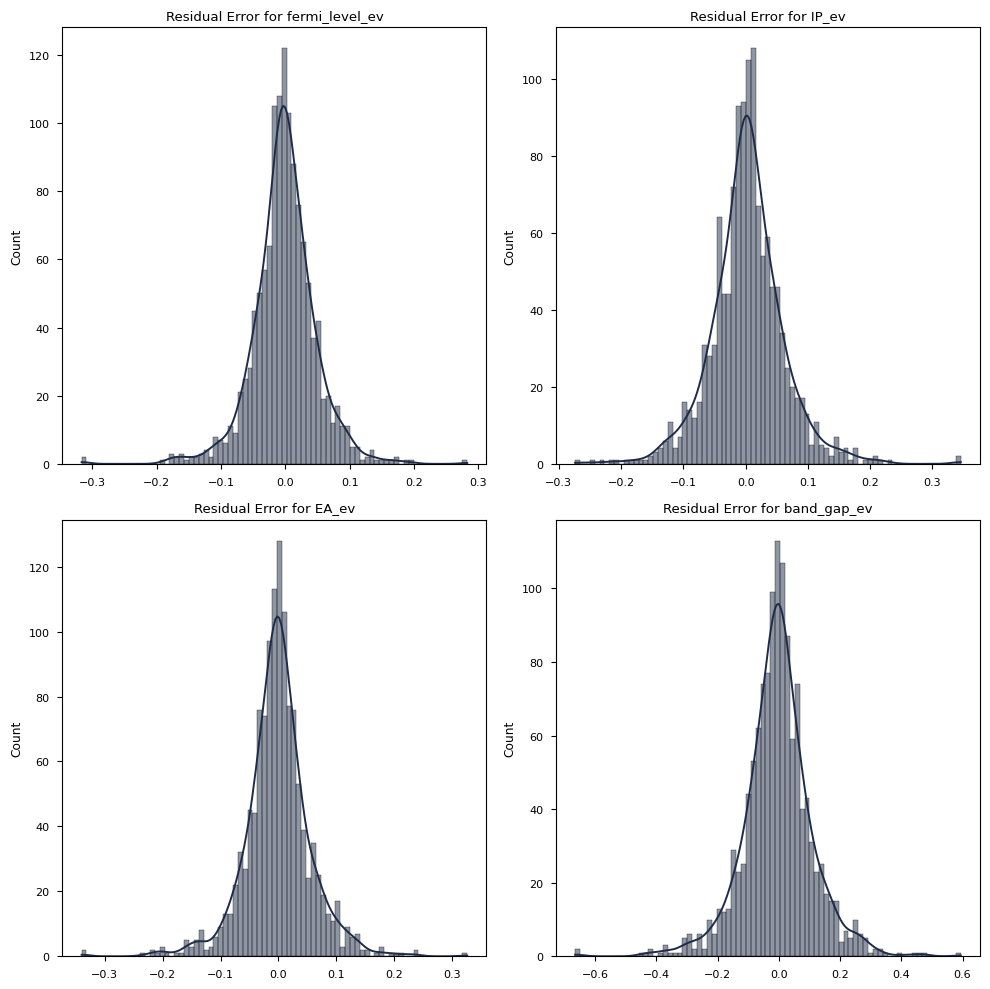

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns


# Definisci il numero di righe e colonne per la griglia dei subplot
num_targets = len(target_list)
num_cols = 2  # Modifica questo valore in base al numero desiderato di colonne
num_rows = -(-num_targets // num_cols)  # Divisione intera arrotondata per eccesso

# Crea la griglia dei subplot
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
fig2, axes2 = plt.subplots(num_rows, num_cols, figsize=(10, 5 * num_rows))

# Flattening dell'array degli assi nel caso ci sia una sola riga o colonna
axes = axes.flatten() if num_targets > 1 else [axes]
axes2 = axes2.flatten() if num_targets > 1 else [axes2]

residual_errors = {}

# Itera su ciascun target nella lista dei target
for i, target in enumerate(target_list):
    ax = axes[i]
    ax2 = axes2[i]
    # Esegui il train-test split per il target corrente
    y = grouped_df[target].values.flatten()
    X_train, X_test, y_train, y_test = train_test_split(
        X_norm, y, test_size=0.2, random_state=3333
    )

    model.fit(X_train, y_train.ravel())
    y_pred = model.predict(X_test)
    residual_errors[target] = y_test - y_pred

    # Calcola le metriche
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Plot della regressione con seaborn
    sns.regplot(
        x=y_test,
        y=y_pred,
        ax=ax,
        scatter_kws={"s": 80},
        color=[31 / 255, 44 / 255, 73 / 255],
        line_kws={"color": "green"},
    )


    sns.histplot(
        residual_errors[target],
        ax=ax2,
        kde=True,
        color=[31 / 255, 44 / 255, 73 / 255],
        bins=int(np.sqrt(X.shape[0])),
        line_kws={"color": "green"},
    )
    ax2.set_title(f"Residual Error for {target}")

    ax.set_title(
        f"Regression Plot for {target}\nMSE: {mse:.2f}, MAE: {mae:.2f}, R2: {r2:.2f}"
    )
    # Aggiungi etichette agli assi x e y
    ax.set_xlabel("Observed")
    ax.set_ylabel("Predicted")


for i in range(num_targets, num_cols * num_rows):
    fig.delaxes(axes[i])

# Regola il layout
plt.tight_layout()
plt.show()

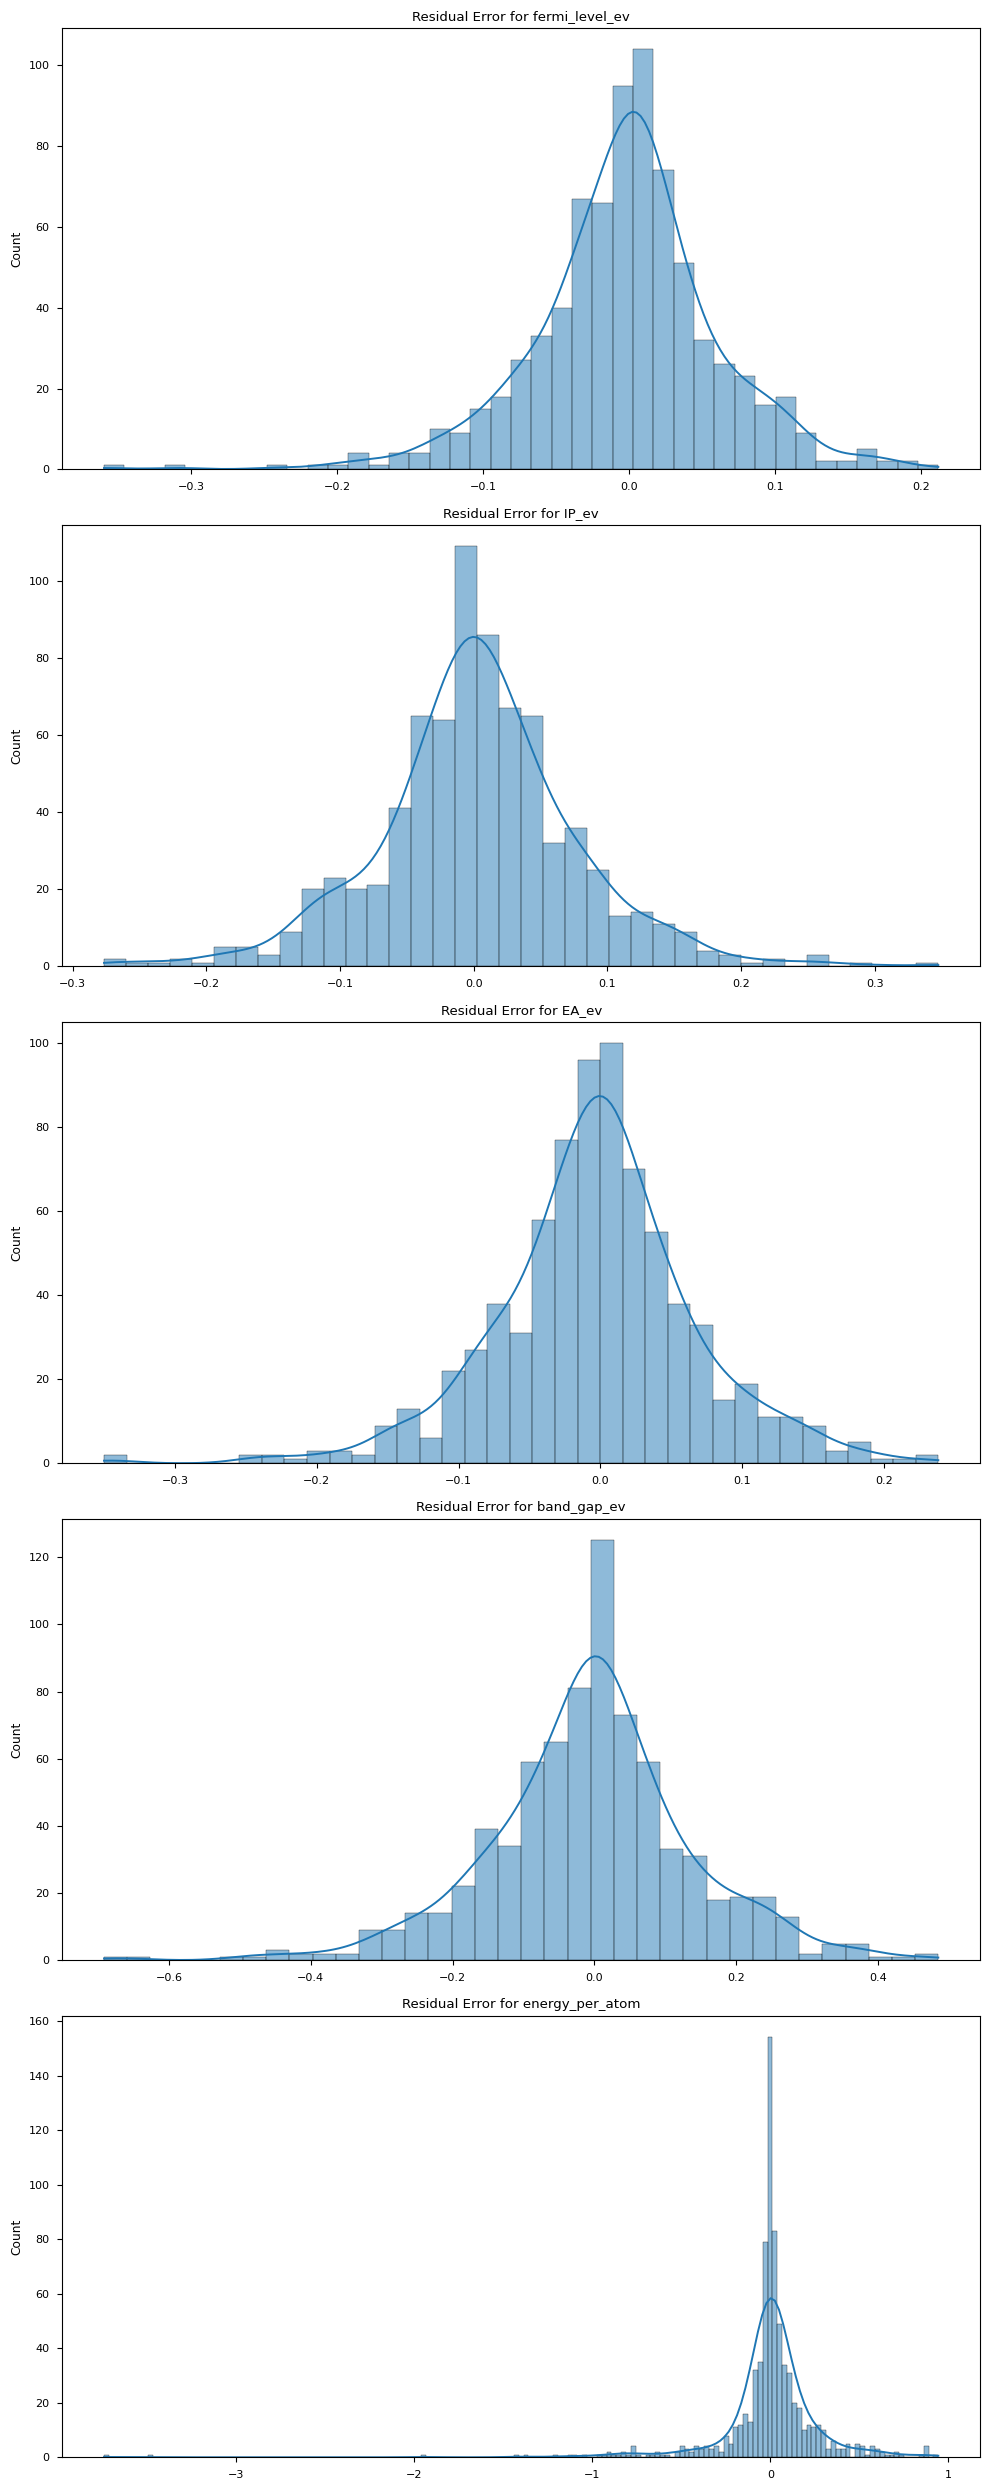

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calcola gli errori residuali per tutti i target
residual_errors = {}
for target in target_list:
    y = grouped_df[target].values.flatten()
    X_train, X_test, y_train, y_test = train_test_split(
        X_norm, y, test_size=0.2, random_state=3333
    )
    model.fit(X_train, y_train.ravel())
    y_pred = model.predict(X_test)
    residual_errors[target] = y_test - y_pred

# Crea un plot per gli errori residuali
fig, axes = plt.subplots(num_targets, 1, figsize=(10, 5 * num_targets))

# Seleziona i subplot per gli errori residuali
axes = axes.flatten() if num_targets > 1 else [axes]

# Itera su ciascun target nella lista dei target
for i, target in enumerate(target_list):
    ax = axes[i]

    # Plot degli errori residuali con seaborn
    sns.histplot(residual_errors[target], ax=ax, kde=True)
    ax.set_title(f"Residual Error for {target}")

# Regola il layout
plt.tight_layout()
plt.show()

In [278]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Calcola l'errore quadratico medio
mse = mean_squared_error(y_test, y_pred)

# Calcola l'errore assoluto medio
mae = mean_absolute_error(y_test, y_pred)

# Calcola il coefficiente di determinazione (R-squared)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared:", r2)

Mean Squared Error (MSE): 0.004046387067014206
Mean Absolute Error (MAE): 0.04574169003555199
R-squared: 0.8458601939692303


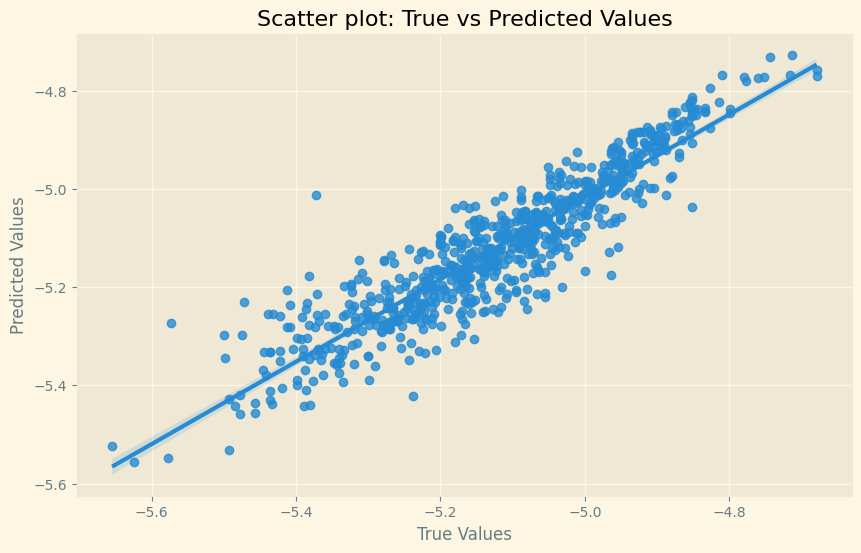

In [279]:
plt.figure(figsize=(10, 6))
sns.regplot(x=np.ravel(y_test), y=np.ravel(y_pred))
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Scatter plot: True vs Predicted Values", color="black")
plt.show()

In [216]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Addestramento del modello Random Forest
rf_model = RandomForestRegressor(
    n_estimators=500, random_state=42
)  # Puoi modificare i parametri a seconda delle tue esigenze
rf_model.fit(X_train, y_train.ravel())

# Predizioni del modello Random Forest
y_pred_rf = rf_model.predict(X_test)

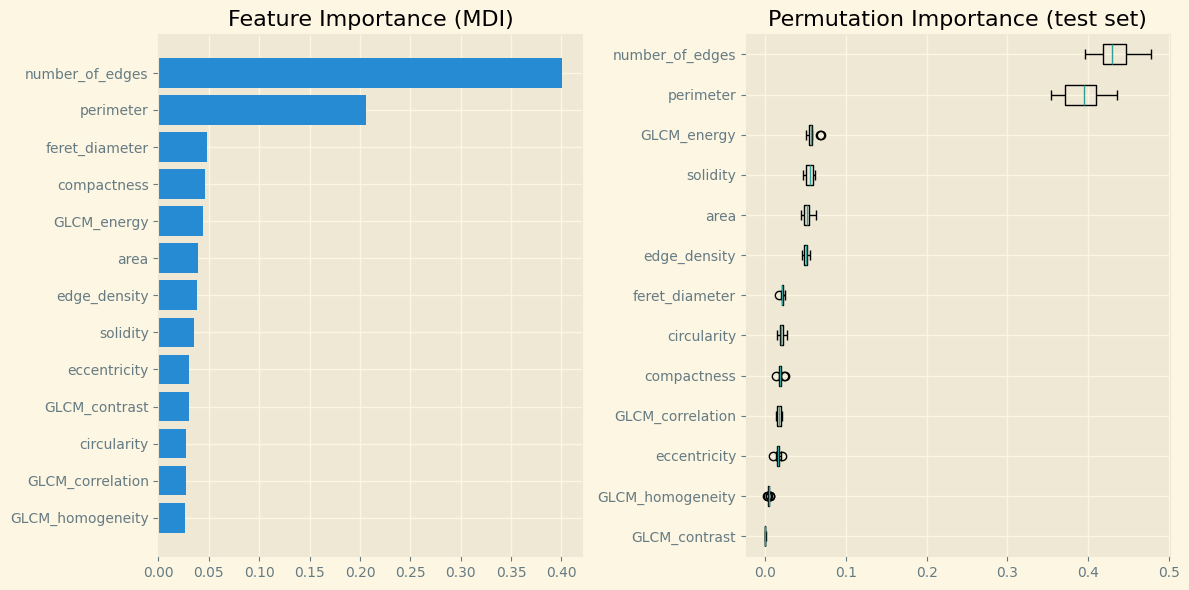

In [228]:
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.array(features_list)[sorted_idx])
plt.title("Feature Importance (MDI)")

result = permutation_importance(
    model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(features_list)[sorted_idx],
)
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

## Set regressor and loss function

## TEST K FOLD
qui con k fold implementato


MEAN R2 scores 0.8426087427783997 with Gradient Boost: 


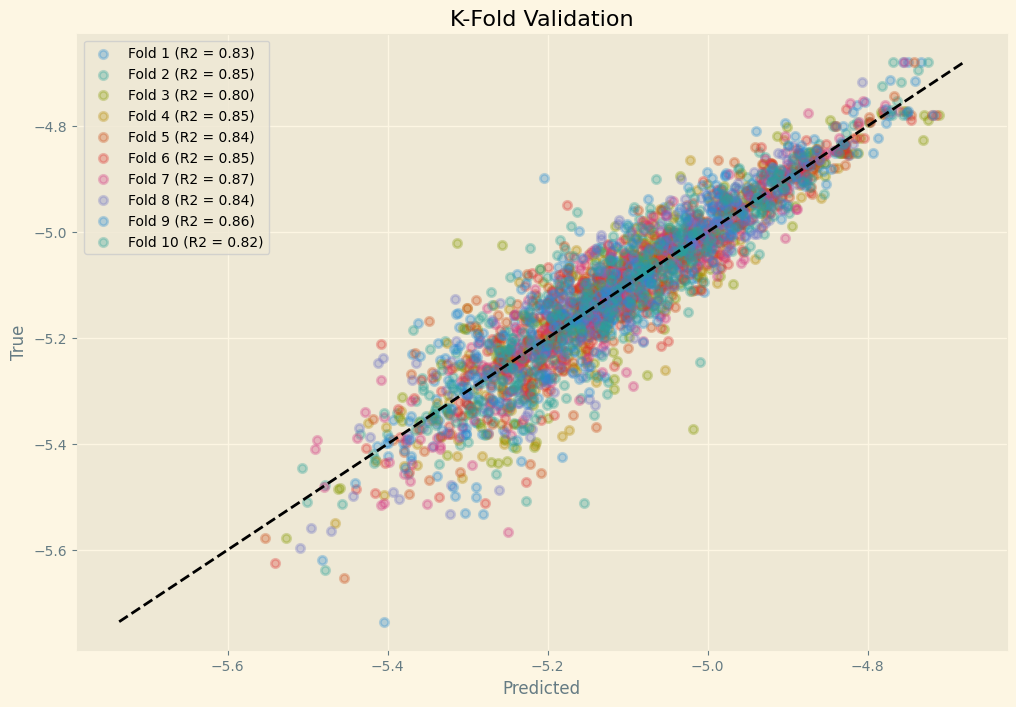

In [229]:
from sklearn import model_selection, metrics
from statistics import mean
import xgboost as xgb
import matplotlib.pyplot as plt

# Definizione dei parametri e inizializzazione del modello
params = {
    "n_estimators": 770,
    "learning_rate": 0.010562915246990538,
    "max_depth": 10,
    "gamma": 0.0002985546393874009,
    "min_child_weight": 1.8685613953859606,
    "colsample_bytree": 0.9633894246849674,
    "subsample": 0.5195778253826636,
}

model_boost = xgb.XGBRegressor(**params)

# Preparazione dei dati
y_train = y_train.ravel()
cv = model_selection.KFold(n_splits=10, random_state=1, shuffle=True)

# Creazione della figura e dell'asse
fig, ax = plt.subplots(figsize=(12, 8))

# Ciclo sui fold di cross-validation
scores = []
for i, (train, test) in enumerate(cv.split(X_train, y_train), start=1):
    prediction = model_boost.fit(X_train[train], y_train[train]).predict(X_train[test])
    true = y_train[test]
    score = metrics.r2_score(true, prediction)
    scores.append(score)
    ax.scatter(
        prediction, true, lw=2, alpha=0.3, label="Fold %d (R2 = %0.2f)" % (i, score)
    )

# Tracciamento della linea di riferimento
ax.plot(
    [min(y_train), max(y_train)],
    [min(y_train), max(y_train)],
    linestyle="--",
    lw=2,
    color="black",
)

# Calcolo e stampa della media dei punteggi R2
mean_r2 = mean(scores)
print("MEAN R2 scores {} with Gradient Boost: ".format(mean_r2))

# Impostazione degli elementi del grafico
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_title("K-Fold Validation", color="black")
ax.legend()

# Impostazione del colore del testo della legenda
for text in ax.get_legend().get_texts():
    text.set_color("black")

# Mostra il grafico
plt.show()

In [328]:
import torch
import torch.nn as nn
from tqdm import tqdm


class NeuralNet(nn.Module):
    def __init__(self, input_dim, num_hidden_layers, hidden_dim, xgb_model):
        super(NeuralNet, self).__init__()
        self.num_hidden_layers = num_hidden_layers
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        # Inizializziamo il primo layer con le feature importance di XGBoost
        xgb_feature_importance = xgb_model.feature_importances_
        self.first_layer = nn.Linear(input_dim, hidden_dim)
        with torch.no_grad():
            self.first_layer.weight.copy_(
                torch.tensor(xgb_feature_importance, dtype=torch.float32).unsqueeze(0)
            )
            self.first_layer.bias.fill_(0.0)

        # Costruiamo i layers hidden
        self.hidden_layers = []
        for _ in range(num_hidden_layers):
            self.hidden_layers.append(nn.Linear(hidden_dim, hidden_dim))
            self.hidden_layers.append(nn.ReLU())

        # Aggiungiamo il layer di output
        self.output_layer = nn.Linear(hidden_dim, 1)

        # Creiamo il modello sequenziale
        layers = [self.first_layer] + self.hidden_layers + [self.output_layer]
        self.sequential = nn.Sequential(*layers)

    def forward(self, x):
        return self.sequential(x)


target = "fermi_level_ev"
features_list = [
    "area",
    "perimeter",
    "circularity",
    "solidity",
    "feret_diameter",
    "compactness",
    "eccentricity",
    "number_of_edges",
    "edge_density",
    "GLCM_correlation",
    "GLCM_energy",
    "GLCM_homogeneity",
    "GLCM_contrast",
]

X = grouped_df[features_list].values

y = grouped_df[target].values.flatten()  # array con tutti i valori raget total_energy

scaler = MinMaxScaler()
X_norm = scaler.fit_transform(X)

scaler2 = MinMaxScaler()
y_norm = scaler2.fit_transform(y.reshape(-1, 1))
# Addestriamo il modello XGBoost
params = {
    "n_estimators": 770,
    "learning_rate": 0.010562915246990538,
    "max_depth": 10,
    "gamma": 0.0002985546393874009,
    "min_child_weight": 1.8685613953859606,
    "colsample_bytree": 0.9633894246849674,
    "subsample": 0.5195778253826636,
}
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=3333
)
xgb_model = xgb.XGBRegressor(**params)
xgb_model.fit(X_train, y_train)

# Definiamo e addestriamo la rete neurale
input_dim = X_train.shape[1]
neural_net = NeuralNet(
    input_dim=input_dim, num_hidden_layers=10, hidden_dim=200, xgb_model=xgb_model
)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(neural_net.parameters(), lr=0.01)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)

for epoch in tqdm(range(1000)):
    optimizer.zero_grad()
    outputs = neural_net(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

# Facciamo previsioni con la rete neurale addestrata
neural_net.eval()
with torch.no_grad():
    neural_predictions = (
        neural_net(torch.tensor(X_test, dtype=torch.float32)).squeeze().numpy()
    )

# Valutiamo le prestazioni della rete neurale
neural_mse = np.mean((neural_predictions - y_test) ** 2)
mse = mean_squared_error(y_test, neural_predictions)

mae = mean_absolute_error(y_test, neural_predictions)

r2 = r2_score(y_test, neural_predictions)
print("MSE della rete neurale:", neural_mse)
print("r2", r2)

100%|██████████| 1000/1000 [00:23<00:00, 42.40it/s]

MSE della rete neurale: 0.026268574848041886
r2 -0.0006539079736822551


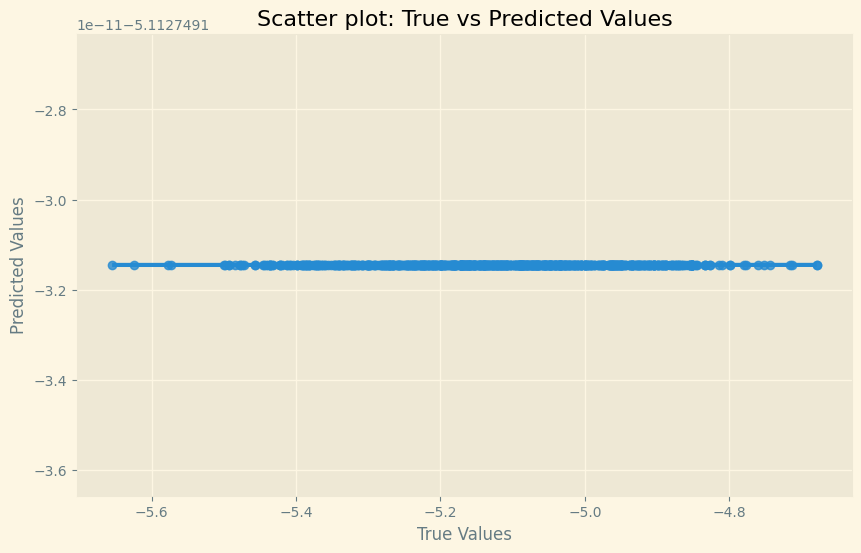

In [329]:
plt.figure(figsize=(10, 6))
sns.regplot(x=np.ravel(y_test), y=np.ravel(neural_predictions))
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Scatter plot: True vs Predicted Values", color="black")
plt.show()

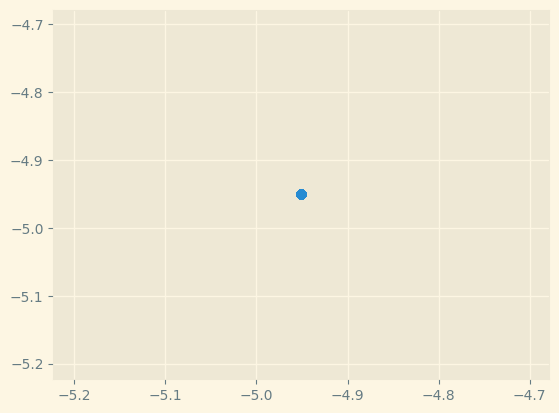

In [314]:
plt.scatter(neural_predictions, neural_predictions)